In [1]:
import time

print("Importing libraries...",end='')
t0 = time.time()

import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from sympy import *
from scipy.sparse.linalg import eigsh
from scipy.linalg import ishermitian
from numpy import sqrt,exp,pi,zeros,arange,copy, sin, pi,loadtxt,poly1d, ones,reshape,floor,linspace
import os.path
import itertools
from numpy import linalg as LA
import matplotlib.pyplot as plt
from numpy import logspace, trapz,conj, linspace,real, imag
import scipy


source = 'DMRG' #'ED' or 'DMRG'
corrsType='raw' # 'raw' or 'normalised'
xs = linspace(-0.5,0.49999,101)
print("DONE in %0.3f [ms]"%(1000*(time.time()-t0)))

Importing libraries...DONE in 999.217 [ms]


In [2]:
def fg(j,n,x,Ns):
    if n==0:
        return 1/sqrt(1/Ns)
    if n==1:
        return sqrt(3*Ns)*(2*x*Ns-2*j-1)
    if n==2:
        return sqrt(5/4*Ns)*(3*(2*x*Ns-2*j-1)**2-1)
    print("ErrG")
    return 0

def double_Integral(xmin, xmax, ymin, ymax, nx, ny, A):

    dS = ((xmax-xmin)/(nx-1)) * ((ymax-ymin)/(ny-1))

    A_Internal = A[1:-1, 1:-1]

    # sides: up, down, left, right
    (A_u, A_d, A_l, A_r) = (A[0, 1:-1], A[-1, 1:-1], A[1:-1, 0], A[1:-1, -1])

    # corners
    (A_ul, A_ur, A_dl, A_dr) = (A[0, 0], A[0, -1], A[-1, 0], A[-1, -1])

    return dS * (np.sum(A_Internal)\
                + 0.5 * (np.sum(A_u) + np.sum(A_d) + np.sum(A_l) + np.sum(A_r))\
                + 0.25 * (A_ul + A_ur + A_dl + A_dr))


def G2(x,xp,Ns,Nn,Corrs2):
    j = floor(x*Ns)
    jp = floor(xp*Ns)
    
    out = 0
    for n in range(Nn):
        for np in range(Nn):
            for npp in range(Nn):
                for nppp in range(Nn):
                    out += fg(j,n,x,Ns)*fg(jp,np,xp,Ns)*fg(jp,npp,xp,Ns)*fg(j,nppp,x,Ns)*Corrs2[j,jp,n,np,npp,nppp]
    return out


def G1(x,xp,Ns,Nn,Corrs1):
    j = floor(x*Ns)
    jp = floor(xp*Ns)
    
    out = 0
    for n in range(Nn):
        for np in range(Nn):
            out += fg(j,n,x,Ns)*fg(jp,np,xp,Ns)*Corrs1[j,n,jp,np]
    return out

def getG1(xs,N,Ns,g,gdd,sigma,maxOcc):
    Corrs1 = {}
    if gdd == 'none':
        filename='./Corrs1/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_g%.6f_maxRange%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,maxRange,source)
        #data = loadtxt('./Corrs2/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.2f_g%.6f_maxRange%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,maxRange,source))
    else:
        if g=='inf':
            filename='./Corrs1/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_ginf_gdd%.6f_sigma%.6f_maxRange%i_maxOcc%i_%s'%(N,Ns,Nn,PBC,Λ,ω,gdd,sigma,maxRange,maxOcc,source)
        else:
            filename='./Corrs1/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_g%.6f_gdd%.6f_sigma%.6f_maxRange%i_maxOcc%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,gdd,sigma,maxRange,maxOcc,source)
    if os.path.isfile(filename):
        data = loadtxt(filename)     
        for row in data:
            Corrs1[tuple([int(x) for x in row[0:-1]])] = float(row[-1])
    
        G1s = zeros((len(xs),len(xs)),dtype=float)
        for ix in range(len(xs)):
            for ixp in range(len(xs)):
                G1s[ix,ixp] = G1(xs[ix],xs[ixp],Ns,Nn,Corrs1)
        #print(xs[1]-xs[0])
       # print(trapz(G1s,xs[1]-xs[0]))
      #  lambda0 = trapz(trapz(G1s,xs[1]-xs[0]),xs[1]-xs[0])
        lambda0 = double_Integral(xs[0], xs[-1], xs[0], xs[-1], len(xs), len(xs), G1s)
        return lambda0/N, [G1s[int(len(xs)/2),i] for i in range(len(xs))]
    return float('nan'), [float('nan')]*len(xs)
            
    


def getG2cutDMRG(xs,Ns,g,gdd,sigma,maxOcc):
    Corrs2 = {}
    if gdd == 'none':
        filename='./Corrs2/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_g%.6f_maxRange%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,maxRange,source)
        #data = loadtxt('./Corrs2/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.2f_g%.6f_maxRange%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,maxRange,source))
    else:
        if g=='inf':
            filename='./Corrs2/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_ginf_gdd%.6f_sigma%.6f_maxRange%i_maxOcc%i_%s'%(N,Ns,Nn,PBC,Λ,ω,gdd,sigma,maxRange,maxOcc,source)
        else:
            filename='./Corrs2/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_g%.6f_gdd%.6f_sigma%.6f_maxRange%i_maxOcc%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,gdd,sigma,maxRange,maxOcc,source)

    if os.path.isfile(filename):
        data = loadtxt(filename)
       # print(len(data))
        # print(data)
        if len(data)>=Ns*Ns*(Nn**4):
            for row in data:
                Corrs2[tuple([int(x) for x in row[0:-1]])] = float(row[-1])


            G2s = zeros(len(xs),dtype=float)

            for ixp in range(len(xs)):
                G2s[ixp] = G2(xs[int(len(xs)/2)],xs[ixp],Ns,Nn,Corrs2)

            return G2s
    return [float('nan')]*len(xs)
    


def getEnergyDMRG(Ns,g,gdd,sigma,maxOcc):
    if gdd == 'none':
        filename='./Energies/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_g%.6f_maxRange%i_maxOcc%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,maxRange,maxOcc,source)
    else:
        if g=='inf':
            filename='./Energies/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_ginf_gdd%.6f_sigma%.6f_maxRange%i_maxOcc%i_%s'%(N,Ns,Nn,PBC,Λ,ω,gdd,sigma,maxRange,maxOcc,source)
        else:
            filename='./Energies/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_g%.6f_gdd%.6f_sigma%.6f_maxRange%i_maxOcc%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,gdd,sigma,maxRange,maxOcc,source)
    print(filename)
    if os.path.isfile(filename):
        data = loadtxt(filename,usecols=(1))
       # print(data)
        if len(data)>1:
            return data[-1]-data[-2]
    return float('nan')

def getEnergyRef(N,g,gdd,sigma,pMax,m):
    data = loadtxt('./program_wojtka-main/data/energies_n%i_pmax%i_ptot0_neig1_m%i_g%.6f_gdd%.6f_sigma%.6f.txt'%(N,pMax,m,g,abs(gdd),sigma))
    return data[0]

def getG2cutRef(N,Ns,g,gdd,sigma,pMax,m):
    pTot=0
    nEig=1
    dataW = np.loadtxt("./program_wojtka-main/data/cov_n%i_pmax%i_ptot%i_neig%i_m%i_g%.6f_gdd%.6f_sigma%.6f.txt"%(N,pMax,pTot,nEig,m,float(g),abs(float(gdd)),sigma))
    return dataW[:,1]

def getXscutRef(N,Ns,g,gdd,sigma,pMax,m):
    pTot=0
    nEig=1
    dataW = np.loadtxt("./program_wojtka-main/data/cov_n%i_pmax%i_ptot%i_neig%i_m%i_g%.6f_gdd%.6f_sigma%.6f.txt"%(N,pMax,pTot,nEig,m,float(g),abs(float(gdd)),sigma))
    return dataW[:,0]

In [3]:
import scipy.optimize as optimize
from math import atan,pi
from numpy import arange
import sympy as sy

#x1,x2,x = symbols('x1,x2,x')

def findDepletion(k,N,lamb):  #WARNING - k must be computed for choosen g!
    return 0
    g=N*lamb
    if N==2:
        print(lamb,end=', ')
        x1,x2,x = sy.symbols('x1,x2,x')
        a12 = (1+(1j*g)/(k[0]-k[1]))
        a21 = (1+(1j*g)/(k[1]-k[0]))

        a12c = conj(a12)
        a21c = conj(a21)
        PsiLL = a12*exp(1j*(k[0]*x1+k[1]*x2))+ a21*exp(1j*(k[1]*x1+k[0]*x2))
        PsiLLc = a12c*exp(-1j*(k[0]*x1+k[1]*x2))+ a21c*exp(-1j*(k[1]*x1+k[0]*x2))

        G1 = (integrate(PsiLLc.subs(x1,0)*PsiLL.subs(x1,x),(x2,x,1))+integrate(PsiLLc.subs(x1,0)*(PsiLL.subs(x2,x)).subs(x1,x2),(x2,0,x))).expand()
        Norm = G1.subs(x,0)
        #print('Im(Norm)=',im(Norm.expand()),' (should be 0)')
        G1 = (G1/re(Norm.expand())).expand()
        #print('G1(0,x)=',G1)
        Λ = (integrate(G1.expand(),(x,0,1))).expand()
        #print('Re(Λ)=',re(Λ),'Im(Λ)=',im(Λ),' (should be 0)')
        return 1-re(Λ)
    return float('nan')

def getEnergyLL(N,lamb):
    g=N*lamb
    I=[]
    if N%1==1:
        n0=-int(N/2)
    else:
        n0 = -(N-1)/2
    for n in arange(n0,n0+N,1):
        I.append(n)

    def a(P,k,g):
        out = 1
        for i in range(0,N):
            for j in range(i+1,N):
                out *=(1+1j*g/(k[P[i]]-k[P[j]]))
        return out

    def computeC(j,k):
        out = k[j]-2*pi*I[j]
        for i in range(0,N):
            out += 2*atan((k[j]-k[i])/g)
        return out

    def f(k):
        out = 0
        for j in range(0,N):
            out += (computeC(j,k))**2
        return out


    initial_guess = [x*pi for x in I]
    result = optimize.minimize(f, initial_guess)
    if result.success:
        k = result.x
        E = sum(k**2)/N/2
        
       # Ps = list(itertools.permutations(range(0,N)))


#         Norm = 0
#         lambda0 = 0
#         for P in Ps:
#             lambda0+= abs(a(P,k,lamb*N))**2*(sin(k[P[1]]/2)/(k[P[1]]/2))**2
#             Norm+= abs(a(P,k,lamb*N))**2
    
        return E, k,findDepletion(k,N,lamb)
    else:
        raise ValueError(result.message)
        
def getGammaEnergyBdG():
    data = loadtxt('./Energies/eqc.txt')
    return data[:,2], data[:,3]

In [6]:
N,Ns,Nn =3,40,3
PBC,Λ,maxRange = 1,10000.0,4
ω,gdd,σ = 0.0,0.0,1/Ns

lambs = [0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
lambsRef = logspace(-2,3,100)



#lambs = [0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]

./Energies/N3_Ns40_Nn3_PBC1_Lambda10000.00_omega0.000000_g0.300000_gdd-0.030000_sigma0.025000_maxRange4_maxOcc3_DMRG
./Energies/N3_Ns40_Nn3_PBC1_Lambda10000.00_omega0.000000_g0.600000_gdd-0.060000_sigma0.025000_maxRange4_maxOcc3_DMRG
./Energies/N3_Ns40_Nn3_PBC1_Lambda10000.00_omega0.000000_g1.500000_gdd-0.150000_sigma0.025000_maxRange4_maxOcc3_DMRG
./Energies/N3_Ns40_Nn3_PBC1_Lambda10000.00_omega0.000000_g3.000000_gdd-0.300000_sigma0.025000_maxRange4_maxOcc3_DMRG
./Energies/N3_Ns40_Nn3_PBC1_Lambda10000.00_omega0.000000_g6.000000_gdd-0.600000_sigma0.025000_maxRange4_maxOcc3_DMRG
./Energies/N3_Ns40_Nn3_PBC1_Lambda10000.00_omega0.000000_g15.000000_gdd-1.500000_sigma0.025000_maxRange4_maxOcc3_DMRG
./Energies/N3_Ns40_Nn3_PBC1_Lambda10000.00_omega0.000000_g30.000000_gdd-3.000000_sigma0.025000_maxRange4_maxOcc3_DMRG
./Energies/N3_Ns40_Nn3_PBC1_Lambda10000.00_omega0.000000_g60.000000_gdd-6.000000_sigma0.025000_maxRange4_maxOcc3_DMRG
./Energies/N3_Ns40_Nn3_PBC1_Lambda10000.00_omega0.000000_g150

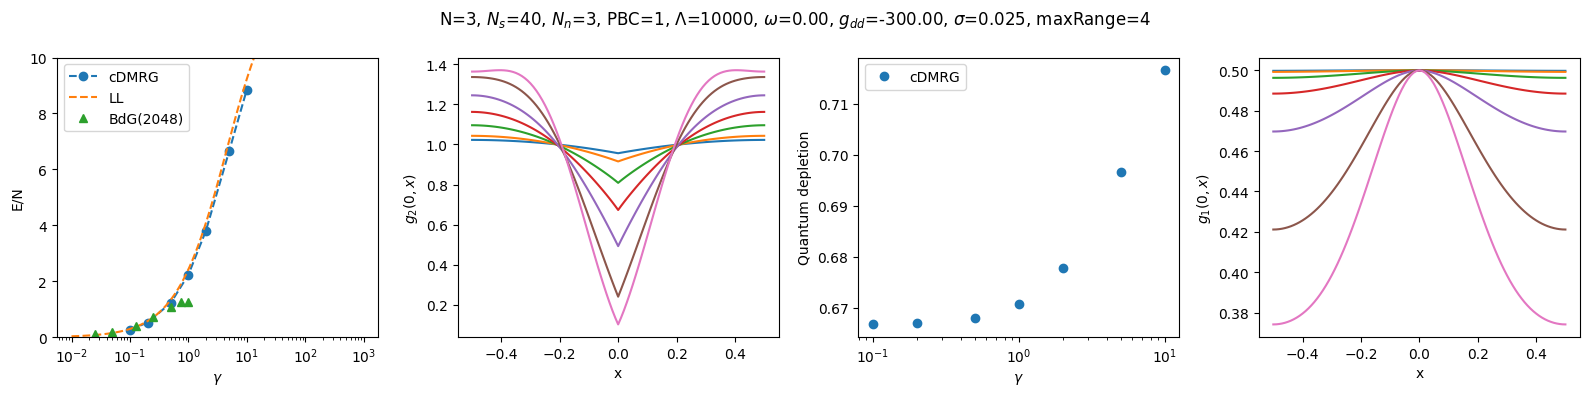

In [7]:
fig, ax = plt.subplots(1,4,figsize=[16,4])

Energies = []
EnergiesMF = []
EnergiesMF_LHY = []
EnergiesLL = []

CondensateDepletioncDMRG = []
CondensateDepletionLL = []


for lamb in lambsRef:
    if lamb==float('inf'):
        g='inf'
        EnergyLL,ks,QDLL = getEnergyLL(N,lamb)
        EnergiesLL.append(EnergyLL)
        CondensateDepletionLL.append(QDLL)
    else:
        g=lamb*N
        EnergiesMF.append(g*N/2)
        EnergiesMF_LHY.append(g*N/2-2/(3*pi)*(g*N)**(3/2)/N)
        EnergyLL,ks,QDLL = getEnergyLL(N,lamb)
        EnergiesLL.append(EnergyLL)
        CondensateDepletionLL.append(QDLL)


for lamb in lambs:
    if lamb==float('inf'):
        g='inf'
        Energies.append(getEnergyDMRG(Ns,g,gdd,σ)/N)
    else:
        g=lamb*N
        gdd = -0.1*lamb*N
        lambda0, G1cut = getG1(xs,N,Ns,g,gdd,σ,maxOcc=min(N,3))
        
        Energies.append(getEnergyDMRG(Ns,g,gdd,σ,maxOcc=min(N,3))/N)
        CondensateDepletioncDMRG.append(1-lambda0/N)
        ax[1].plot(xs,[x/N/(N-1) for x in getG2cutDMRG(xs,Ns,g,gdd,σ,maxOcc=min(N,3))],label=r'$\lambda$=%.2f'%(lamb))
        ax[3].plot(xs,[x/N/(N-1) for x in G1cut],label=r'$\lambda$=%.2f'%(lamb))


ax[0].plot(lambs,Energies,'o--',label='cDMRG')
#ax[0].plot(lambsRef,EnergiesMF,'--',label='MF')
#ax[0].plot(lambsRef,EnergiesMF_LHY,'--',label='MF+LHY')
ax[0].plot(lambsRef,EnergiesLL,'--',label='LL')
lambsBdG,EBdG = getGammaEnergyBdG()
ax[0].plot(lambsBdG,[0.5*lambsBdG[i]*N**2-EBdG[i] for i in range(len(EBdG))],'^',label='BdG(2048)')

ax[0].set_xscale('log')
ax[0].set_ylabel('E/N')
ax[0].set_xlabel(r'$\gamma$')
ax[0].legend()
#ax[0].set_xlim([0.05,4])
# ax[0].set_ylabel(r'$G_2(0,x)$')
ax[1].set_xlabel('x')
ax[1].set_ylabel(r'$g_2(0,x)$')
ax[3].set_xlabel('x')
ax[3].set_ylabel(r'$g_1(0,x)$')
##ax[0].set_ylim([-0.1,14.1])
ax[0].set_ylim([0,int(max(Energies)*1.1+0.5)])
#ax[0].set_ylim([-0.1,int(Energies[lambs.index(2)]*1.1+0.5)+0.1])

ax[2].plot(lambs,[x for x in CondensateDepletioncDMRG],'o',label='cDMRG')
#ax[2].plot(lambsRef,[1-(1-x)**(1/2) for x in CondensateDepletionLL],'--',label='LL')
ax[2].set_xscale('log')
ax[2].set_ylabel('Quantum depletion')
ax[2].set_xlabel(r'$\gamma$')
#ax[2].set_xlim([0.05,4])
ax[2].legend()
#ax[0].set_ylim([-0.1,int(max(EnergiesLL)*1.1+0.5)+0.1])
fig.suptitle('N=%i, $N_s$=%i, $N_n$=%i, PBC=%i, $\Lambda$=%i, $\omega$=%.2f, $g_{dd}$=%.2f, $\sigma$=%.3f, maxRange=%i'%(N,Ns,Nn,PBC,Λ,ω,gdd,σ,maxRange))
plt.tight_layout()
plt.savefig('./figures/DMRG_zoom_N%i_$N_s$%i_$N_n$%i_PBC%i_$\Lambda$%i_$\omega$%.2f.png'%(N,Ns,Nn,PBC,Λ,ω),dpi=300)
#ax[1].legend()
plt.show()

In [ ]:
print(EnergiesLL)
print(EnergiesMF)
print(Energies)

In [232]:
print(Energies[lambs.index(2)])
print(lambs)
print(Energies)

4.0657129
[0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
[0.29257755766666665, 0.5711670366666667, 1.3339681700000001, 2.4112027333333335, 4.0657129, 6.962953333333332, 9.115178333333333, 10.728404333333335, 11.954207666666667, 12.416321333333334, 12.661718333333333, 12.822340666666667, 12.887701666666667]
